# Modeling of scRNA-seq with a VAE Demo

First, we create a `PertDataset` object to load and handle scRNA-seq data.
We specify that we want to load the `norman` dataset.

In [1]:
import pertdata as pt

norman = pt.PertDataset(name="norman", cache_dir_path="data", silent=False)

Downloading: https://dataverse.harvard.edu/api/access/datafile/6154020 -> /workspaces/amlg/src/demos/scrna_vae_demo/data/norman/data.zip
Total size: 168,758,985 bytes


100%|██████████| 169M/169M [00:15<00:00, 10.6MiB/s] 


Download completed: /workspaces/amlg/src/demos/scrna_vae_demo/data/norman/data.zip
Loading: /workspaces/amlg/src/demos/scrna_vae_demo/data/norman/norman/perturb_processed.h5ad


The actual data is stored in an [`AnnData`](https://anndata.readthedocs.io/en/latest/) object.
`AnnData` is specifically designed for matrix-like data.
By this we mean that we have $n$ observations, each of which can be represented as $d$-dimensional vectors, where each dimension corresponds to a variable or feature.
Both the rows and columns of this $n \times d$-matrix are special in the sense that they are indexed.
For instance, in scRNA-seq data, each row corresponds to a cell with a barcode, and each column corresponds to a gene with a gene identifier.

In [2]:
print(norman)
print(norman.adata)
print(norman.adata.X.shape)  # type: ignore

PertDataset object
    name: norman
    cache_dir_path: /workspaces/amlg/src/demos/scrna_vae_demo/data
    path: /workspaces/amlg/src/demos/scrna_vae_demo/data/norman
    adata: AnnData object with n_obs ✕ n_vars = 91205 ✕ 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
(91205, 5045)


In general, in a perturbation dataset, we find $k$ cell lines.
Usually, one cell line remains unperturbed, and the others are cultivated separately (with different perturbations, i.e., gene knockouts).
The mRNA of usually a few thousand cells of each cell line is sequenced, generating the $n$ $d$-dimensional gene expression profiles.
In particular, perturbation labels are available (i.e., we know which genes were knocked out in each cell line).

Before we can take a closer look at our data, we need to fix the perturbation labels, because they might be expressed ambiguously (e.g., single-gene perturbations can be expressed as `ctrl+<gene1>` or `<gene1>+ctrl`, falsely leading to two distinct labels for the perturbation of `<gene1>`).

In [3]:
import pandas as pd


def generate_fixed_perturbation_labels(labels: pd.Series) -> pd.Series:
    """Generate fixed perturbation labels.

    In the perturbation datasets, single-gene perturbations are expressed as:
    - ctrl+<gene1>
    - <gene1>+ctrl

    Double-gene perturbations are expressed as:
    - <gene1>+<gene2>

    However, in general, there could also be multi-gene perturbations, and they
    might be expressed as a string with additional superfluous "ctrl+" in the
    middle:
        - ctrl+<gene1>+ctrl+<gene2>+ctrl+<gene3>+ctrl

    Hence, we need to remove superfluous "ctrl+" and "+ctrl" matches, such that
    perturbations are expressed as:
    - <gene1> (single-gene perturbation)
    - <gene1>+<gene2> (double-gene perturbation)
    - <gene1>+<gene2>+...+<geneN> (multi-gene perturbation)

    Note: Control cells are not perturbed and are labeled as "ctrl". We do not
    modify these labels.

    Args:
        labels: The perturbation labels.

    Returns:
        The fixed perturbation labels.
    """
    # Remove "ctrl+" and "+ctrl" matches.
    labels_fixed = labels.str.replace(pat="ctrl+", repl="")
    labels_fixed = labels_fixed.str.replace(pat="+ctrl", repl="")

    return labels_fixed


print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")

norman.adata.obs["condition_fixed"] = generate_fixed_perturbation_labels(
    labels=norman.adata.obs["condition"]
)

filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


Because gene expression data is very sparse, i.e., the expression is often not measured successfully or correctly, we will limit our experiment to the 128 genes with the highest variances.

In [4]:
import anndata


def select_top_genes(adata: anndata.AnnData, num_genes: int) -> anndata.AnnData:
    """Select the top genes with the highest variances.

    Args:
        adata: AnnData object containing gene expression data.
        num_genes: Number of top genes to select.

    Returns:
        AnnData object with only the top genes.
    """
    # Compute the gene variances.
    gene_variances = adata.X.toarray().var(axis=0)  # type: ignore

    # Sort the gene variances in descending order and get the indexes of the top genes.
    sorted_indexes = gene_variances.argsort()[::-1]
    top_gene_indexes = sorted_indexes[:num_genes]

    # Get the gene names and variances of the top genes.
    top_genes = adata.var["gene_name"].iloc[top_gene_indexes]
    top_variances = gene_variances[top_gene_indexes]

    # Print the top genes with the highest variances.
    print(f"Top {num_genes} genes with highest variances:")
    for gene, variance in zip(top_genes, top_variances):
        print(f"{gene:15}: {variance:.2f}")

    # Create and return a new AnnData object with only the top genes.
    return adata[:, top_gene_indexes].copy()


# Use the function to select the top genes.
d = 128
adata_single_top_genes = select_top_genes(adata=adata_single, num_genes=d)

Top 128 genes with highest variances:
HBZ            : 1.69
HIST1H4C       : 1.69
HBG2           : 1.15
HIST1H1C       : 0.85
HBG1           : 0.73
NEAT1          : 0.71
UBE2S          : 0.62
GYPB           : 0.61
MALAT1         : 0.58
TOP2A          : 0.58
VIM            : 0.57
HMGB2          : 0.56
SH3BGRL3       : 0.55
RP11-301G19.1  : 0.53
HIST1H2BJ      : 0.52
CENPF          : 0.49
GAL            : 0.48
MT-ND6         : 0.48
RP11-717F1.1   : 0.47
APOE           : 0.47
PTTG1          : 0.47
CKS1B          : 0.47
CKS2           : 0.46
TUBB           : 0.46
GYPA           : 0.46
KIAA0101       : 0.46
S100A11        : 0.45
PHF19          : 0.44
PSMA4          : 0.44
HNRNPH1        : 0.44
CACYBP         : 0.43
KRT18          : 0.43
BTG1           : 0.43
LDHA           : 0.43
SLC25A37       : 0.42
CFD            : 0.42
AIF1           : 0.42
LGALS1         : 0.41
NME1           : 0.41
HSPA8          : 0.41
BLVRB          : 0.41
HN1            : 0.41
SRM            : 0.41
BIRC5          :

First, we prepare our data.

Note that we shuffle the data in the `train_loader` but not in the `test_loader`.

Shuffling the training data is a common practice to ensure that the model does not learn the order of the data.
It helps in breaking correlations by preventing the model from learning any unintended patterns or correlations that might exist in the order of the training data.

Shuffling is typically not used for the testing data because non-shuffled data ensures that the evaluation is consistent and reproducible.
The model is tested on the same data in the same order each time, which is important for comparing performance across different runs.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the gene expression matrix to a PyTorch tensor.
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)  # type: ignore

# Create a PyTorch dataset.
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

# Number of workers.
num_workers = 3

# Create train and test data loaders.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
)

scRNA-seq data provides a high-dimensional representation of gene expression profiles across individual cells.
Analyzing such data often requires dimensionality reduction techniques to uncover meaningful biological patterns while reducing noise and sparsity.

Variational Autoencoders (VAEs) are a type of deep generative model that are particularly well-suited for scRNA-seq data.
Unlike traditional dimensionality reduction methods like PCA, VAEs learn a probabilistic latent space that captures the underlying structure of the data.

This latent space enables:

- Data denoising: VAEs can reconstruct gene expression profiles while mitigating technical noise.
- Latent representations: The learned low-dimensional embeddings can reveal cell states, trajectories, and perturbation effects.
- Generative modeling: VAEs can generate synthetic data, which is useful for simulating experiments or augmenting datasets.

In [6]:
import pytorch_lightning as pl
from vae import VAE

# Get the number of features.
n_features = X.shape[1]
print(f"n_features={n_features}")

# Get the number of samples.
n_samples = X.shape[0]
print(f"n_samples={n_samples}")

# Create the VAE.
vae = VAE(in_features=n_features, latent_dim=16, loss_type="mse_kld")

n_features=128
n_samples=55760


Next, we train the VAE:

In [7]:
from pytorch_lightning.loggers import CSVLogger

# Initialize the CSV logger.
logger = CSVLogger(save_dir="lightning_logs", name="vae_experiment")

# Train the VAE.
trainer = pl.Trainer(max_epochs=4, logger=logger)
trainer.fit(model=vae, train_dataloaders=train_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params | Mode  | FLOPs
------------------------------------------------------------
0 | encoder      | Sequential | 27.3 K | train | 0    
1 | mu_layer     | Linear     | 528    | train | 0    
2 | logvar_layer | Linear     | 528    | train | 0    
3 | decoder      | Sequential | 27.7 K | train | 0    
------------------------------------------------------------
56.0 K    Trainable params
0         Non-trainable params
56.0 K    Total params
0.224     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 3: 100%|██████████| 697/697 [00:09<00:00, 73.54it/s, v_num=0, batch_idx=696.0, train_loss=0.395, recon_loss=0.374, kl_loss=0.0211]  

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 697/697 [00:09<00:00, 73.50it/s, v_num=0, batch_idx=696.0, train_loss=0.395, recon_loss=0.374, kl_loss=0.0211]


Then, we test the model:

In [8]:
# Test the VAE.
trainer.test(model=vae, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 175/175 [00:01<00:00, 150.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_kl_loss         0.019732937216758728
        test_loss           0.36810365319252014
     test_recon_loss        0.34837064146995544
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.36810365319252014,
  'test_recon_loss': 0.34837064146995544,
  'test_kl_loss': 0.019732937216758728}]

Then we plot the training loss:

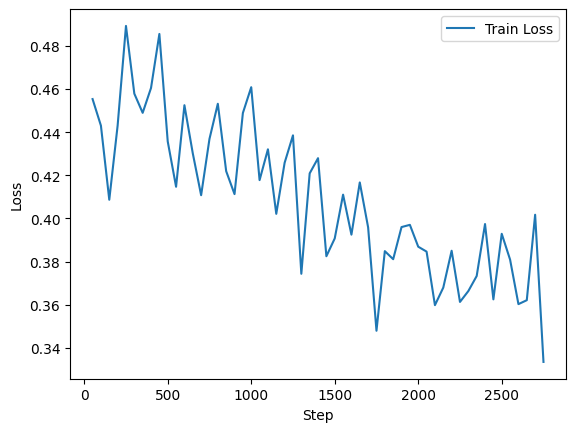

In [9]:
import os

import matplotlib.pyplot as plt
import pandas as pd


def plot_train_loss(logfile: str) -> None:
    """Plot the training loss from a PyTorch Lightning log file."""
    log = pd.read_csv(filepath_or_buffer=logfile)
    plt.plot(log["step"], log["train_loss"], label="Train Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# Construct the path to the most recent version directory.
most_recent_metrics_file = os.path.join(
    logger.save_dir, logger.name, f"version_{logger.version}", "metrics.csv"
)

# Plot the training loss.
plot_train_loss(logfile=most_recent_metrics_file)

The t-SNE visualization provides a 2D representation of the latent space (μ) learned by the VAE.

Here, we:

1. Pass the input data through the VAE to obtain the latent mean (μ), which represents the encoded data.
2. Use t-SNE to reduce the dimensionality of μ to two dimensions for visualization.
3.Visualize the 2D t-SNE projection, where each point corresponds to a cell, and the spatial arrangement reflects similarities in their gene expression profiles.

This visualization helps assess whether the VAE has captured meaningful structure in the data, such as clustering of cells with similar states or perturbations.

A continuous or sequential structure in the 2D t-SNE plot could indicate:

1. Over-regularization:
If the KL divergence term in the VAE's loss function is too dominant, the latent space may collapse into a simpler structure, such as a line or curve.
This can happen if the model is overly constrained to make the latent space smooth, at the expense of capturing more complex relationships.
2. Dimensionality reduction artifact:
t-SNE is a non-linear dimensionality reduction technique, and it can sometimes distort the true structure of the high-dimensional latent space.
3. Insufficient latent dimensions:
If the latent space dimensionality is too small, the VAE may struggle to capture the full complexity of the data.
This can force the model to compress the data into a simpler structure.

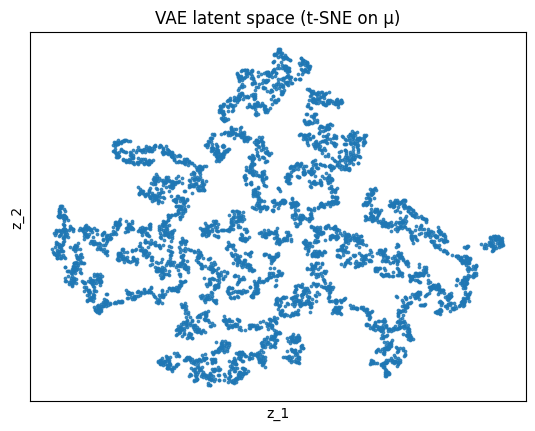

In [10]:
import numpy as np
from sklearn.manifold import TSNE

vae.eval()

with torch.no_grad():
    _, Z_mu, _ = vae(X)
    Z_mu = Z_mu.numpy()

# t-SNE on a random subset.
idx = np.random.choice(len(Z_mu), size=min(5000, len(Z_mu)), replace=False)
Z2 = TSNE(
    n_components=2,
    init="pca",
    perplexity=30,
    random_state=96,
).fit_transform(Z_mu[idx])

plt.scatter(Z2[:, 0], Z2[:, 1], s=3, alpha=0.8)
plt.title("VAE latent space (t-SNE on μ)")
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.xticks([])
plt.yticks([])
plt.show()


To evaluate the performance of the VAE, we compare the original gene expression profiles with their reconstructed counterparts.
This comparison helps us understand how well the VAE captures the underlying structure of the data.
By visualizing these heatmaps side by side, we can assess the quality of reconstruction.
Ideally, the reconstructed data should closely resemble the original data, indicating that the VAE has effectively learned meaningful representations.

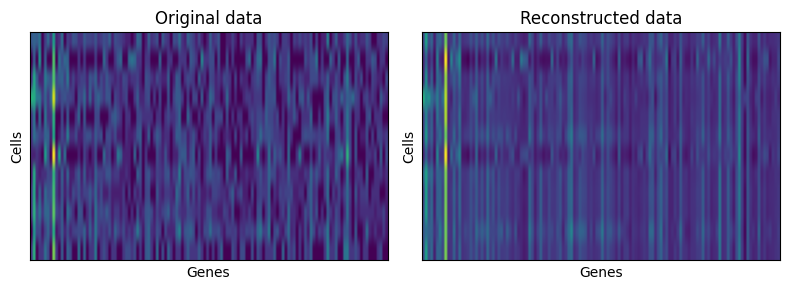

In [11]:
# Randomly select a small subset of cells for visualization.
sel = np.random.default_rng(0).choice(len(X), size=12, replace=False)
x = X[sel].detach().clone()

# Reconstruct selected cells.
vae.eval()
with torch.no_grad():
    x_hat, _, _ = vae(x)

# Convert to NumPy for plotting.
x, x_hat = x.numpy(), x_hat.numpy()

# Plot original vs. reconstructed heatmaps.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, (data, title) in enumerate(
    zip([x, x_hat], ["Original data", "Reconstructed data"])
):
    ax[i].imshow(data, aspect="auto")
    ax[i].set_title(title)
    ax[i].set_xlabel("Genes")
    ax[i].set_ylabel("Cells")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()